<a href="https://colab.research.google.com/github/Pondza555/Fraud-Detection/blob/main/Credit_Card_Approval_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Set basics library & data

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

record = pd.read_csv("/content/drive/MyDrive/Dataset/application_record.csv")
credit = pd.read_csv("/content/drive/MyDrive/Dataset/credit_record.csv")

## 1. Explore data

### 1.1 View data

* There are NULL or NAN.

In [54]:
record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [55]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [56]:
record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [57]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


### 1.2 Check "NULL" & "NaN"

* Has NULL or NaN around 130,000 of 430,000 which around 30%, but it only one feature.

In [58]:
(record.isnull() | (record == 'NULL')).sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [59]:
(credit.isnull() | (credit == 'NULL')).sum()

,0
ID,0
MONTHS_BALANCE,0
STATUS,0


## 2. Adjust data

### 2.1 Merge data & Set target risk

* I choose user who overdue for more than 60 days to be target risk.
* We face imbalance dataset.

In [106]:
begin_month = credit.groupby("ID")["MONTHS_BALANCE"].min().reset_index()
begin_month.rename(columns={'MONTHS_BALANCE': 'begin_month'}, inplace=True)
new_data = pd.merge(record, begin_month, how="left", on="ID")

credit['risk'] = credit['STATUS'].isin(['2', '3', '4', '5']).astype(int)

cpunt = credit.groupby('ID')['risk'].sum().reset_index()
cpunt['risk'] = cpunt['risk'].apply(lambda x: 'Yes' if x > 0 else 'No')

new_data = pd.merge(new_data, cpunt, how='inner', on='ID')
new_data['target'] = new_data['risk'].map({'Yes': 1, 'No': 0})
new_data.drop('risk',axis=1,inplace=True)

print(new_data['target'].value_counts())
new_data['target'].value_counts(normalize=True)

target
0    35841
1      616
Name: count, dtype: int64


,proportion
target,
0,0.983103
1,0.016897


### 2.2 Check "NULL", "NaN" after merge

In [61]:
(new_data.isnull() | (new_data == 'NULL')).sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


### 2.3 Manage "NULL", "NaN"

* Due to 30% of data in occupation has lost, I decided to drop this columns because I want to keep 36000 data for training model instead of lose it 30%.

In [107]:
new_data.drop('OCCUPATION_TYPE',axis=1,inplace=True)

### 2.4 Change columns name for ease of use


In [108]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Property',
                         'CNT_CHILDREN':'Child','AMT_INCOME_TOTAL':'Annual_income','NAME_INCOME_TYPE':'Income_type',
                         'NAME_EDUCATION_TYPE':'Education_type','NAME_FAMILY_STATUS':'Family_status',
                        'NAME_HOUSING_TYPE':'House_type','DAYS_BIRTH':'Age_day','DAYS_EMPLOYED':'Employed_age',
                         'FLAG_MOBIL':'Mobile_phone','FLAG_EMAIL':'Email','FLAG_WORK_PHONE':'Working_phone',
                         'FLAG_PHONE':'House_phone','CNT_FAM_MEMBERS':'Family_size'
                        },inplace=True)

### 2.5 Scaling numeric data

* Actually this topic is for regression based model, but I use tree based model so if you want to use regression you can scaling data to make it fit for training.
* Standard scaler is for common data
* Robust scaler is for data with outliner

In [109]:
## Annual_income, Employed_age, begin_month for robust
## Age_day, Family_size for standard
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler

new_data['Annual_income_rscal'] = RobustScaler().fit_transform(new_data['Annual_income'].values.reshape(-1,1))
new_data['Employed_age_rscal'] = RobustScaler().fit_transform(new_data['Employed_age'].values.reshape(-1,1))
new_data['begin_month_rscal'] = RobustScaler().fit_transform(new_data['begin_month'].values.reshape(-1,1))

new_data['Age_day_sscal'] = StandardScaler().fit_transform(new_data['Age_day'].values.reshape(-1,1))
new_data['Family_size_sscal'] = StandardScaler().fit_transform(new_data['Family_size'].values.reshape(-1,1))

new_data.drop(['Annual_income','Employed_age','begin_month','Age_day','Family_size'],axis=1,inplace=True)
new_data.columns

Index(['ID', 'Gender', 'Car', 'Property', 'Child', 'Income_type',
       'Education_type', 'Family_status', 'House_type', 'Mobile_phone',
       'Working_phone', 'House_phone', 'Email', 'target',
       'Annual_income_rscal', 'Employed_age_rscal', 'begin_month_rscal',
       'Age_day_sscal', 'Family_size_sscal'],
      dtype='object')

### 2.6 Change categorical data to numerica for model calculation

* This "label encoders" are more suitable for decision tree models than regression.
* Why I not use "one hot encoders" to use logistic regression, because this dataset has a lot of categorical. It create more feature which cause overfit to regression based model.
* Then I will use XGBoost in this dataset.

In [110]:
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['Gender', 'Car', 'Property', 'Income_type', 'Education_type',
                    'Family_status', 'House_type']

df_tree = new_data.copy()
for col in categorical_cols:
    df_tree[col] = LabelEncoder().fit_transform(df_tree[col])

In [111]:
df_tree.head()

,ID,Gender,Car,Property,Child,Income_type,Education_type,Family_status,House_type,Mobile_phone,Working_phone,House_phone,Email,target,Annual_income_rscal,Employed_age_rscal,begin_month_rscal,Age_day_sscal,Family_size_sscal
0,5008804,1,1,1,0,4,1,0,4,1,1,0,0,0,2.608696,-1.089253,0.333333,0.945169,-0.217680
1,5008805,1,1,1,0,4,1,0,4,1,1,0,0,0,2.608696,-1.089253,0.370370,0.945169,-0.217680
2,5008806,1,1,1,0,4,4,1,1,1,0,0,0,0,-0.434783,0.152277,-0.185185,-1.309091,-0.217680
3,5008808,0,0,1,0,0,4,3,1,1,0,1,1,0,1.086957,-0.546084,0.740741,-0.746300,-1.314564
4,5008809,0,0,1,0,0,4,3,1,1,0,1,1,0,1.086957,-0.546084,-0.074074,-0.746300,-1.314564


### 2.7 Split data

* Prepare for training and test model.

In [113]:
from sklearn.model_selection import train_test_split
X = df_tree.drop(['ID','target'], axis=1)
y = df_tree['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=77)

## 3. Modeling XGBoost

### 3.1 Bayes-search

* I use BayesSearchCV instead of GridSearchCV and RandomSearchCV, because I want to use less time for train model.
* Hyperparameter I choose is common use, if you want to use other thing you can do it.

In [ ]:
!pip install scikit-optimize

In [114]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy = 0.1 ,random_state=77)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

search_space = {
    'xgb__max_depth': (3, 10),
    'xgb__learning_rate': (0.01, 0.3, 'log-uniform'),
    'xgb__n_estimators': (50, 300),
    'xgb__subsample': (0.5, 1.0, 'uniform'),
    'xgb__colsample_bytree': (0.5, 1.0, 'uniform'),
}

opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=30,
    cv=StratifiedKFold(n_splits=3),
    scoring='f1',
    n_jobs=-1,
    random_state=77
)

opt.fit(X_train, y_train)

print("Best Parameters:", opt.best_params_)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:04:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: OrderedDict([('xgb__colsample_bytree', 0.5), ('xgb__learning_rate', 0.29999999999999993), ('xgb__max_depth', 7), ('xgb__n_estimators', 300), ('xgb__subsample', 1.0)])


## 4. Analyze

### 4.1 Importance feature

* We can see feature that are numerical has more importance than categorical. This is because the frequency of feature express more signal than categorical which make model detect more importance.

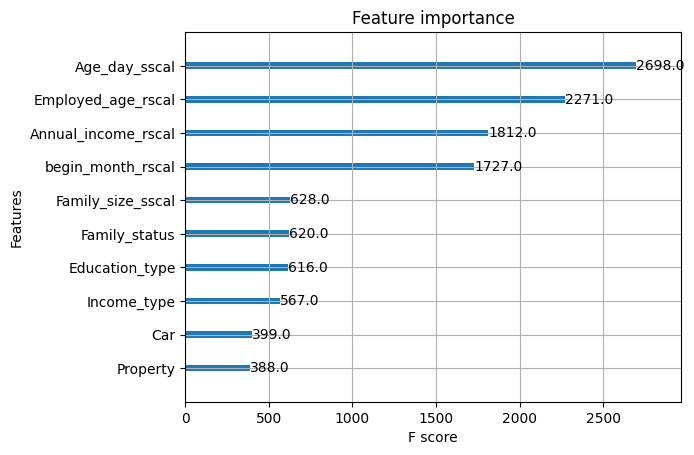

In [115]:
from xgboost import plot_importance

best_model = opt.best_estimator_
xgb_model = best_model.named_steps['xgb']

plot_importance(xgb_model, max_num_features=10)
plt.show()

### 4.2 Precision & Recall

* The result of recall and precision isn't impressive even I use any techique skill.

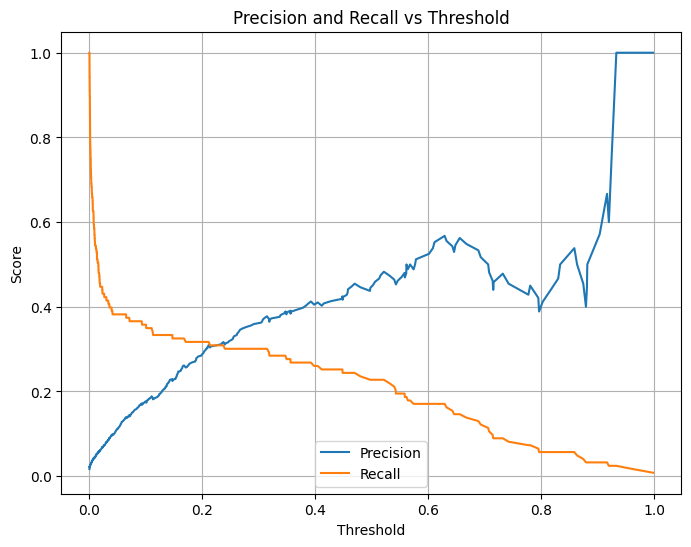

In [116]:
from sklearn.metrics import precision_recall_curve

best_model = opt.best_estimator_
y_scores = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### 4.3 Confusion matrix

* ✅ TN (True Negative) = 7135 Predicted as 0 and was correct
* ❌ FP (False Positive) = 34 Predicted as 1 but was actually 0
* ❌ FN (False Negative) = 95 Predicted as 0 but was actually 1 (Missed approval)
* ✅ TP (True Positive) = 28 Predicted as 1 and was correct

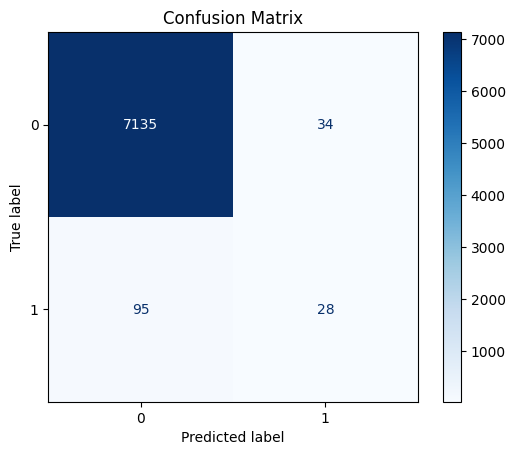

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [118]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Precision: 0.45161290322580644
Recall: 0.22764227642276422
F1-score: 0.3027027027027027


### 4.4 ROC curve

* AUC = 0.78 isn't impressive but moderate classify.

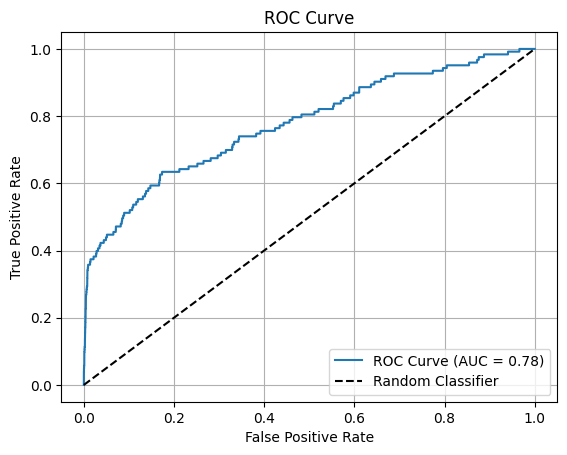

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5. Conclusion

1. This data has imbalance dataset, NaN or NULL in one feature which need to fix. I fix imbalance by SMOTE and fix NaN or NULL by drop feature out.
2. My goal is to less approve on overdue user for more than 60 days to decrease business financial damage. But the model isn't well perform, maybe data is a lot of categorical and less signal for model to predict who is deserve approval.
3. I has try logistic regression and it still bad as XGBoost, but I haven't try neural network so if you want to use this dataset, maybe you should try other model especially neural network. Why I not use? because it take too long time to process and my goal doing this and many project is to know many technique and solve real problem such as NULL and imbalance dataset. I have only 2 months to practice before study again in university so I need to improve a lot before my time is due.
4. Lastly, if there is any mistake, please tell me. I'm happy to listen.